# LAGalaxy Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 6 # galaxy

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25762 entries, 0 to 25761
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              25762 non-null  int64  
 1   dimCustomerMasterId       25762 non-null  int64  
 2   customerNumber            25762 non-null  object 
 3   year                      25762 non-null  object 
 4   productGrouping           25762 non-null  object 
 5   totalSpent                25762 non-null  float64
 6   recentDate                25762 non-null  object 
 7   attendancePercent         25762 non-null  float64
 8   renewedBeforeDays         25429 non-null  float64
 9   isBuyer                   25762 non-null  object 
 10  source_tenure             25429 non-null  float64
 11  tenure                    25429 non-null  float64
 12  distToVenue               25762 non-null  float64
 13  totalGames                25762 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25762 entries, 0 to 25761
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          25762 non-null  int64  
 1   dimCustomerMasterId   25762 non-null  int64  
 2   customerNumber        25762 non-null  object 
 3   year                  25762 non-null  object 
 4   productGrouping       25762 non-null  object 
 5   totalSpent            25762 non-null  float64
 6   recentDate            25762 non-null  object 
 7   attendancePercent     25762 non-null  float64
 8   renewedBeforeDays     25429 non-null  float64
 9   isBuyer               25762 non-null  object 
 10  source_tenure         25429 non-null  float64
 11  tenure                25429 non-null  float64
 12  distToVenue           25762 non-null  float64
 13  totalGames            25762 non-null  int64  
 14  recency               25762 non-null  int64  
 15  missed_games_1     

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (23186, 49)
Unseen Data For Predictions: (2576, 49)
Data for Modeling (A Class): (23186, 49)
Unseen Data For Predictions: (2576, 49)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(25762, 32)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25762 entries, 0 to 25761
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   totalSpent         25762 non-null  float64
 1   renewedBeforeDays  25429 non-null  float64
 2   source_tenure      25429 non-null  float64
 3   tenure             25429 non-null  float64
 4   totalGames         25762 non-null  int64  
 5   recency            25762 non-null  int64  
 6   missed_games_1     25762 non-null  int64  
 7   missed_games_2     25762 non-null  int64  
 8   click_link         25762 non-null  int64  
 9   open_email         25762 non-null  int64  
 10  send_email         25762 non-null  int64  
 11  openToSendRatio    25762 non-null  float64
 12  clickToSendRatio   25762 non-null  float64
 13  isNextYear_Buyer   25762 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 2.8 MB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,totalSpent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,click_link,open_email,send_email,openToSendRatio,clickToSendRatio,isNextYear_Buyer
totalSpent,1.00,0.08,0.02,0.02,0.21,-0.00,0.10,0.07,-0.01,-0.01,0.01,-0.04,-0.01,0.07
renewedBeforeDays,0.08,1.00,0.38,0.38,0.36,0.06,0.24,0.14,0.11,0.19,0.20,0.09,0.03,0.44
source_tenure,0.02,0.38,1.00,1.00,-0.02,-0.06,-0.04,-0.04,0.34,0.49,0.57,0.35,0.14,0.21
tenure,0.02,0.38,1.00,1.00,-0.02,-0.06,-0.04,-0.04,0.34,0.49,0.57,0.35,0.14,0.21
totalGames,0.21,0.36,-0.02,-0.02,1.00,-0.09,0.47,0.18,0.04,0.07,0.06,-0.07,-0.02,0.37
recency,-0.00,0.06,-0.06,-0.06,-0.09,1.00,0.08,0.14,-0.11,-0.12,-0.10,-0.12,-0.08,-0.09
missed_games_1,0.10,0.24,-0.04,-0.04,0.47,0.08,1.00,0.19,-0.10,-0.08,-0.06,-0.14,-0.08,0.15
missed_games_2,0.07,0.14,-0.04,-0.04,0.18,0.14,0.19,1.00,-0.10,-0.09,-0.08,-0.12,-0.07,0.05
click_link,-0.01,0.11,0.34,0.34,0.04,-0.11,-0.10,-0.10,1.00,0.67,0.55,0.49,0.62,0.13
open_email,-0.01,0.19,0.49,0.49,0.07,-0.12,-0.08,-0.09,0.67,1.00,0.81,0.71,0.28,0.20


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (20610, 14)
Unseen Data For Predictions: (5152, 14)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [17]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "openToSendRatio",
        "clickToSendRatio"
    ]
)

,Description,Value
0,session_id,1817
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(20610, 14)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


(<MLUsecase.CLASSIFICATION: 1>,
 None,
 {'parameter': 'Hyperparameters',
  'auc': 'AUC',
  'confusion_matrix': 'Confusion Matrix',
  'threshold': 'Threshold',
  'pr': 'Precision Recall',
  'error': 'Prediction Error',
  'class_report': 'Class Report',
  'rfe': 'Feature Selection',
  'learning': 'Learning Curve',
  'manifold': 'Manifold Learning',
  'calibration': 'Calibration Curve',
  'vc': 'Validation Curve',
  'dimension': 'Dimensions',
  'feature': 'Feature Importance',
  'feature_all': 'Feature Importance (All)',
  'boundary': 'Decision Boundary',
  'lift': 'Lift Chart',
  'gain': 'Gain Chart',
  'tree': 'Decision Tree',
  'ks': 'KS Statistic Plot'},
 8421     0
 4506     1
 19407    0
 761      0
 12539    1
         ..
 14379    1
 19437    1
 9389     0
 1536     1
 15792    0
 Name: isNextYear_Buyer, Length: 4122, dtype: int64,
 False,
 None,
 1817,
 [('Setup Config',
                                  Description             Value
   0                               session_id 

In [13]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8124,0.8757,0.8790,0.8144,0.8454,0.6078,0.6107,0.0860
7,Random Forest Classifier,0.8025,0.8661,0.8676,0.8081,0.8367,0.5875,0.5899,0.5470
9,Extreme Gradient Boosting,0.8025,0.8680,0.8626,0.8111,0.8360,0.5884,0.5903,1.0090
2,Gradient Boosting Classifier,0.7998,0.8686,0.8783,0.7987,0.8366,0.5797,0.5841,0.5630
8,NGBClassifier,0.7908,0.8585,0.8817,0.7859,0.8310,0.5587,0.5652,5.9250
3,Extra Trees Classifier,0.7902,0.8511,0.8573,0.7982,0.8266,0.5619,0.5642,0.4480
0,Ada Boost Classifier,0.7813,0.8505,0.8664,0.7823,0.8222,0.5401,0.5449,0.1640
6,Logistic Regression,0.7592,0.8016,0.8271,0.7755,0.8004,0.4978,0.4996,0.4830
4,K Neighbors Classifier,0.7346,0.7807,0.8135,0.7520,0.7815,0.4448,0.4473,0.0790
1,Decision Tree Classifier,0.7229,0.7163,0.7576,0.7653,0.7614,0.4310,0.4311,0.0480


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [14]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8029,0.8787,0.8732,0.8054,0.8379,0.5876,0.5907
1,0.8132,0.8807,0.8825,0.8132,0.8465,0.6091,0.6124
2,0.8035,0.8629,0.8784,0.8032,0.8391,0.5881,0.5920
3,0.8296,0.9019,0.8857,0.8328,0.8584,0.6449,0.6469
4,0.8241,0.8804,0.8888,0.8237,0.8550,0.6324,0.6354
5,0.8102,0.8759,0.8742,0.8141,0.8431,0.6037,0.6061
6,0.8144,0.8813,0.8732,0.8203,0.8459,0.6133,0.6152
7,0.8144,0.8724,0.8733,0.8205,0.8461,0.6131,0.6150
8,0.8034,0.8598,0.8711,0.8073,0.8380,0.5889,0.5917
9,0.8083,0.8625,0.8898,0.8030,0.8442,0.5967,0.6020


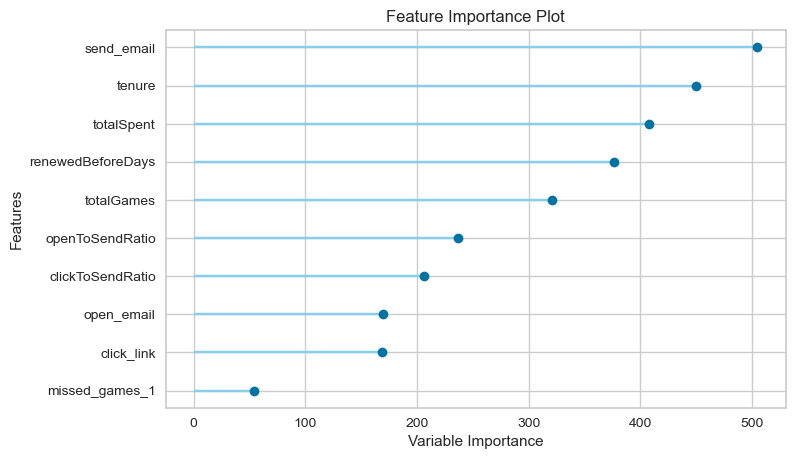

In [15]:
plot_model(best_model, plot='feature')

In [16]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?